# Advanced Numpy Techniques

<img src="assets/numpylogo.png" alt="http://www.numpy.org/#">

General, user-friendly [documentation](https://docs.scipy.org/doc/numpy/index.html) with lots of examples.

Technical, "hard" [reference](https://docs.scipy.org/doc/numpy/reference/index.html#reference).

Dataquest [cheat sheet](https://www.dataquest.io/blog/images/cheat-sheets/numpy-cheat-sheet.pdf).

Basic Python knowledge assumed, see [here](https://github.com/ASvyatkovskiy/PythonWorkshop/blob/Spring2017/1_PythonBasics/PythonBasics.ipynb).

CPython ~3.6, NumPy ~1.12

## What is it?

[NumPy](http://www.numpy.org/) is an open-source package that's part of the [SciPy](https://scipy.org/) ecosystem. Its main feature is an array object of arbitrary dimension, but this fundamental collection is integral to any data-focused Python application.


<table>
<tr>
<th>
<img src="assets/nonsteeplearn.png" width="200" alt="http://gabriellhanna.blogspot.com/2015/03/negatively-accelerated-learning-curve-i.html">
</th><th>
<img src="assets/steeplearn.jpg" width="200" alt="http://malaher.org/2007/03/pet-peeve-learning-curve-misuse/">
</th></tr></table>

Most people learn numpy through assimilation or necessity. I believe NumPy has the latter learning curve (steep/easy to learn), so you can actually invest just a little bit of time now (by going through this notebook, for instance), and reap a lot of reward!

# Motivation

* Provide a uniform interface for handling numerical structured data
* Collect, store, and manipulate numerical data efficiently
* Low-cost abstractions
* Universal glue for numerical information, used in lots of external libraries!


<table>
<tr>
<th>
<img src="assets/numba.png" alt="http://numba.pydata.org/" width="150"></th><th><img src="assets/pandas.png" alt="http://pandas.pydata.org/"  width="150"> </th><th><img src="assets/tf.png" alt="https://github.com/tensorflow/tensorflow" width="150"></th><th> <img src="assets/sklearn.png" alt="https://github.com/scikit-learn/scikit-learn" width="150"> </th><th><img src="assets/stan.png" alt="http://mc-stan.org/" width="150"></th>
</tr>
</table>



# Goals and Non-goals

### Goals

What I'll do:

* Give a bit of basics first.
* Describe NumPy, with under-the-hood details to the extent that they are useful to you, the user
* Highlight some [GOTCHA]s, avoid some common bugs
* Point out a couple useful NumPy functions

**This is not an attempt to exaustively cover the reference manual (there's too many individual functions to keep in your head, anyway).**

Instead, I'll try to...

* provide you with an overview of the API structure so next time you're doing numeric data work you'll know where to look
* convince you that NumPy arrays offer the perfect data structure for the following (wide-ranging) use case:

**RAM-sized general-purpose structured numerical data applications: manipulation, collection, and analysis.**

### Non-goals

* No emphasis on multicore processing, but will be briefly mentioned
* Some NumPy functionality not covered -- mentioned briefly at end
* HPC concerns
* GPU programming

# Why not a Python list?

A list is a resizing contiguous array of pointers.

<img src="assets/pylist.png" alt="http://www.laurentluce.com/posts/python-list-implementation/">

Nested lists are even worse - there are two levels of indirection.

<img src="assets/nestlist.png" alt="http://www.cs.toronto.edu/~gpenn/csc401/401_python_web/pyseq.html">

Imagine we're trying to apply a read or write operation over these arrays on our modern CPU:

<img src="assets/vecproc.gif" alt="http://www.netlib.org/utk/papers/advanced-computers_2004_10_14/sm-simd.html">

Compare to NumPy arrays:

<img src="assets/nparr.png" alt="https://www.safaribooksonline.com/library/view/python-for-data/9781491957653/ch04.html" width=300>

**Recurring theme**: NumPy lets us have the best of both worlds (high-level Python for development, optimized representation and speed via low-level C routines for execution)

In [1]:
import numpy as np
import time
import gc
import sys

assert sys.maxsize > 2 ** 32, "get a new computer!"

# Allocation-sensitive timing needs to be done more carefully
# Compares runtimes of f1, f2
def compare_times(f1, f2, setup1=None, setup2=None, runs=5):
    print('    format: mean seconds (standard error)', runs, 'runs')
    maxpad = max(len(f.__name__) for f in (f1, f2))
    means = []
    for setup, f in [[setup1, f1], [setup2, f2]]:
        setup = (lambda: tuple()) if setup is None else setup
        
        total_times = []
        for _ in range(runs):
            try:
                gc.disable()
                args = setup()
                
                start = time.time()
                if isinstance(args, tuple):
                    f(*args)
                else:
                    f(args)
                end = time.time()
                
                total_times.append(end - start)
            finally:
                gc.enable()
                
        mean = np.mean(total_times)
        se = np.std(total_times) / np.sqrt(len(total_times))
        print('    {} {:.2e} ({:.2e})'.format(f.__name__.ljust(maxpad), mean, se))
        means.append(mean)
    print('    improvement ratio {:.1f}'.format(means[0] / means[1]))

### Bandwidth-limited ops

* Have pull in more cache lines for the pointers
* Poor locality causes pipeline stalls

In [4]:
print('create a list')
size = 10 ** 7 # ints will be un-intered past 258

def create_list(): return list(range(size))
def create_array(): return np.arange(size, dtype=int)

compare_times(create_list, create_array)

create a list
    format: mean seconds (standard error) 5 runs
    create_list  3.14e-01 (1.01e-02)
    create_array 2.17e-02 (5.76e-04)
    improvement ratio 14.4


In [5]:
print('deep copies (no pre-allocation)') # Shallow copy is cheap for both!
size = 10 ** 7

ls = list(range(size))
def copy_list(): return ls[:]

ar = np.arange(size, dtype=int)
def copy_array(): return np.copy(ar)

compare_times(copy_list, copy_array)

deep copies (no pre-allocation)
    format: mean seconds (standard error) 5 runs
    copy_list  8.26e-02 (2.77e-03)
    copy_array 1.53e-02 (4.31e-04)
    improvement ratio 5.4


In [6]:
print('Deep copy (pre-allocated)')
size = 10 ** 7

def create_lists(): return list(range(size)), [0] * size
def deep_copy_lists(src, dst): dst[:] = src

def create_arrays(): return np.arange(size, dtype=int), np.empty(size, dtype=int)
def deep_copy_arrays(src, dst): dst[:] = src

compare_times(deep_copy_lists, deep_copy_arrays, create_lists, create_arrays)

Deep copy (pre-allocated)
    format: mean seconds (standard error) 5 runs
    deep_copy_lists  7.86e-02 (8.65e-04)
    deep_copy_arrays 1.48e-02 (3.55e-04)
    improvement ratio 5.3


### Flop-limited ops

* Can't engage VPU on non-contiguous memory: won't saturate CPU computational capabilities of your hardware.

In [7]:
print('square out-of-place')

def square_lists(src, dst):
    for i, v in enumerate(src):
        dst[i] = v * v

def square_arrays(src, dst):
    np.square(src, out=dst)
    
compare_times(square_lists, square_arrays, create_lists, create_arrays)

square out-of-place
    format: mean seconds (standard error) 5 runs
    square_lists  9.60e-01 (9.45e-03)
    square_arrays 1.37e-02 (2.16e-04)
    improvement ratio 70.2


In [8]:
# Caching and SSE can have huge cumulative effects

print('square in-place')
size = 10 ** 7

def create_list(): return list(range(size))
def square_list(ls):
    for i, v in enumerate(ls):
        ls[i] = v * v

def create_array(): return np.arange(size, dtype=int)
def square_array(ar):
    np.square(ar, out=ar)
    
compare_times(square_list, square_array, create_list, create_array)

square in-place
    format: mean seconds (standard error) 5 runs
    square_list  9.43e-01 (1.30e-02)
    square_array 9.56e-03 (3.51e-04)
    improvement ratio 98.6


### Memory consumption

List representation uses 8 extra bytes for every value (assuming 64-bit here and henceforth)!

In [9]:
from pympler import asizeof
size = 10 ** 4

print('list  kb', asizeof.asizeof(list(range(size))) // 1024)
print('array kb', asizeof.asizeof(np.arange(size, dtype=int)) // 1024)

list  kb 400
array kb 78


### Disclaimer

Regular python lists are still useful! They do a lot of things arrays can't:

* List comprehensions `[x * x for x in range(10) if x % 2 == 0]`
* Ragged nested lists `[[1, 2, 3], [1, [2]]]`
* Contain arbitrary objects

# The NumPy Array

[doc](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html#internal-memory-layout-of-an-ndarray)

### Abstraction

We know what a array is -- a contiugous chunk of memory holding an indexed list of things. If the things have a particular type, using, say, `dtype` as a placeholder, then we can refer to this as a `classical_array` of `dtype`s.

The NumPy array, an `ndarray` with a _datatype, or dtype,_ `dtype` is an _N_-dimensional array for arbitrary _N_. This is defined recursively:
* For _N > 0_, an _N_-dimensional `ndarray` of _dtype_ `dtype` is a `classical_array` of _N - 1_ dimensional `ndarray`s of _dtype_ `dtype`, all with the same size.
* For _N = 0_, the `ndarray` is a `dtype`

We note some familiar special cases:
* _N = 0_, we have a scalar, or the datatype itself
* _N = 1_, we have a `classical_array`
* _N = 2_, we have a matrix

Each _axis_ has its own `classical_array` length: this yields the shape.

In [25]:
n0 = np.array(3, dtype=float)
n1 = np.stack([n0, n0, n0, n0])
n2 = np.stack([n1, n1])
n3 = np.stack([n2, n2])

for x in [n0, n1, n2, n3]:
    print('ndim', x.ndim, 'shape', x.shape)
    print(x)

ndim 0 shape ()
3.0
ndim 1 shape (4,)
[ 3.  3.  3.  3.]
ndim 2 shape (2, 4)
[[ 3.  3.  3.  3.]
 [ 3.  3.  3.  3.]]
ndim 3 shape (2, 2, 4)
[[[ 3.  3.  3.  3.]
  [ 3.  3.  3.  3.]]

 [[ 3.  3.  3.  3.]
  [ 3.  3.  3.  3.]]]


**Axes are read LEFT to RIGHT: an array of shape `(n0, n1, ..., nN-1)` has axis `0` with length `n0`, etc.**

### Detour: Formal Representation

Formally, a NumPy array can be viewed as a mathematical object. If:

* The `dtype` belongs to some set $F$
* The array has dimension $N$, with the $i$-th axis having length $n_i$
* $N>1$

Then this array is an object in:

$$
F^{n_0}\otimes F^{n_{1}}\otimes\cdots \otimes F^{n_{N-1}}
$$

$F^n$ is an $n$-dimensional vector field over $F$. An element in here can be represented by its canonical basis $\textbf{e}_i^{(n)}$ as a sum for elements $f_i\in F$:

$$
f_1\textbf{e}_1^{(n)}+f_{2}\textbf{e}_{2}^{(n)}+\cdots +f_{n}\textbf{e}_{n}^{(n)}
$$

$F^n\otimes F^m$ is a tensor product, which takes two vector fields and gives you another. Then the tensor product is a special kind of vector field with dimension $nm$. Elements in here have a special structure which we can tie to the original vector fields $F^n,F^m$:

$$
\sum_{i=1}^n\sum_{j=1}^mf_{ij}(\textbf{e}_{i}^{(n)}\otimes \textbf{e}_{j}^{(m)})
$$

Above, $(\textbf{e}_{i}^{(n)}\otimes \textbf{e}_{j}^{(m)})$ is a basis vector of $F^n\otimes F^m$ for each pair $i,j$.

We will discuss what $F$ can be later; but most of this intuition (and a lot of NumPy functionality) is based on $F$ being a type corresponding to a field.

# Back to CS / Mutability / Losing the Abstraction

The above is a (simplified) view of `ndarray` as a tensor, but gives useful intuition for arrays that are **not mutated**.

An `ndarray` **Python object** is a actually a _view_ into a shared `ndarray`. The _base_ is a representative of the equaivalence class of views of the same array

<img src="assets/ndarrayrep.png" alt="https://docs.scipy.org/doc/numpy/reference/arrays.html">

**This diagram is a lie!**

In [33]:
original = np.arange(10)

# shallow copies
s1 = original[:]
s2 = s1.view()
s3 = original[:5]

print(original)

[0 1 2 3 4 5 6 7 8 9]


In [34]:
original[2] = -1
print('s1', s1)
print('s2', s2)
print('s3', s3)

s1 [ 0  1 -1  3  4  5  6  7  8  9]
s2 [ 0  1 -1  3  4  5  6  7  8  9]
s3 [ 0  1 -1  3  4]


In [36]:
id(original), id(s1.base), id(s2.base), id(s3.base)

(140434859351216, 140434859351216, 140434859351216, 140434859351216)

### Dtypes

$F$ (our `dtype`) can be ([doc](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html)):

* boolean
* integral
* floating-point
* complex floating-point
* any structure ([record array](https://docs.scipy.org/doc/numpy/user/basics.rec.html)) of the above, e.g. [complex integral values](http://stackoverflow.com/questions/13863523/is-it-possible-to-create-a-numpy-ndarray-that-holds-complex-integers)

The `dtype` can also be unicode, a date, or an arbitrary object, but those don't form fields. This means that most NumPy functions aren't usful for this data, since it's not numeric. Why have them at all?

* for all: NumPy `ndarray`s offer the tensor abstraction described above.
* unicode: consistent format in memory for bit operations and for I/O **[GOTCHA: don't use `np.chararray`, it's outdated]**
* [date](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html): compact representation, addition/subtraction, basic parsing

In [38]:
# Names are pretty intuitive for basic types
i16 = np.arange(100, dtype=np.uint16)
i64 = np.arange(100, dtype=np.uint64)
print('i16', asizeof.asizeof(i16), 'i64', asizeof.asizeof(i64))

i16 296 i64 896


In [48]:
# We can use arbitrary structures for our own types
# For example, exact Gaussian (complex) integers

gauss = np.dtype([('re', np.int32), ('im', np.int32)])
c2 = np.zeros(2, dtype=gauss)
c2[0] = (1, 1)
c2[1] = (2, -1)

def print_gauss(g):
    print('{}{:+d}i'.format(g['re'], g['im']))
          
print(c2)
for x in c2:
    print_gauss(x)

[(1,  1) (2, -1)]
1+1i
2-1i


In [98]:
l16 = np.array(5, dtype='>u2') # little endian signed char
b16 = l16.astype('<u2') # big endian unsigned char
print(l16.tobytes(), np.binary_repr(l16, width=16))
print(b16.tobytes(), np.binary_repr(b16, width=16))

b'\x00\x05' 0000000000000101
b'\x05\x00' 0000000000000101


# Indexing [doc](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

Probably the most creative, unique part of the entire library. This is what makes NumPy `ndarray` better than any other array.

And index returns an `ndarray` view based on the other `ndarray`.

### Basic Indexing

In [140]:
x = np.arange(10)

# start:stop:step
# inclusive start, exclusive stop
print(x)
print(x[2:6:2])
print(id(x), id(x[2:6:2].base))

[0 1 2 3 4 5 6 7 8 9]
[2 4]
140435356383552 140435356383552


In [107]:
# Default start is 0, default end is length-1, default step is 1
print(x[:3])
print(x[7:])

[0 1 2]
[7 8 9]


In [141]:
# Don't worry about overshooting
print(x[:100])
print(x[7:2:1])

[0 1 2 3 4 5 6 7 8 9]
[]


In [108]:
# Negatives wrap around (taken mod length of axis)
print(x[-4:-1])

[6 7 8]


In [111]:
# An array whose index goes up in reverse
print(x[::-1])
print(x[::-1][:3])

[9 8 7 6 5 0 1 2 3 4]
[9 8 7]


In [174]:
# What happens if we do an ascending sort on an array with the same index?
x = np.arange(10)

print('x[:5]               ', x[:5])
print('x[:5][::-1]         ', x[:5][::-1])
x[:5][::-1].sort()
print('x[:5][::-1] (sorted)', x[:5][::-1])
print('x[:5] (rev-sorted)  ', x[:5])
print('x                   ', x)

x[:5]                [0 1 2 3 4]
x[:5][::-1]          [4 3 2 1 0]
x[:5][::-1] (sorted) [0 1 2 3 4]
x[:5] (rev-sorted)   [4 3 2 1 0]
x                    [4 3 2 1 0 5 6 7 8 9]


In [180]:
# Multi-dimensional

def display(exp):
    print(exp, eval(exp + '.shape'))
    print(eval(exp))
    print()
    
x = np.arange(4 * 4 * 2).reshape(2, 4, 4)
display('x')
display('x[1, :, :1]')

x (2, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[1, :, :1] (4, 1)
[[16]
 [20]
 [24]
 [28]]



In [181]:
# Add as many length-1 axes as you want [we'll see why later]
y = np.arange(2 * 2).reshape(2, 2)
display('y')
display('y[:, :, np.newaxis]')
display('y[np.newaxis, :, :, np.newaxis]')

y (2, 2)
[[0 1]
 [2 3]]

y[:, :, np.newaxis] (2, 2, 1)
[[[0]
  [1]]

 [[2]
  [3]]]

y[np.newaxis, :, :, np.newaxis] (1, 2, 2, 1)
[[[[0]
   [1]]

  [[2]
   [3]]]]



In [182]:
# Programatically create indices
def f(): return slice(0, 2, 1)
s = f()
print('slice', s.start, s.stop, s.step)
display('x[0, 0, s]')
# equivalent notation
display('x[tuple([0, 0, s])]')
display('x[(0, 0, s)]')

slice 0 2 1
x[0, 0, s] (2,)
[0 1]

x[tuple([0, 0, s])] (2,)
[0 1]

x[(0, 0, s)] (2,)
[0 1]



In [184]:
# GOTCHA: accidentally invoking advanced indexing
display('x[(0, 0, 1),]')
display('x[(0, 0, 1)]')

x[(0, 0, 1),] (3, 4, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]]

x[(0, 0, 1)] ()
1



Basic indices let us access hyper-rectangles with strides:

<img src="assets/slices.png" alt="http://www.scipy-lectures.org/intro/numpy/numpy.html" width="300">

### Advanced Indexing

Arbitrary combinations of basic indexing. **GOTCHA: All advanced index results are copies, not views**.

Advanced indexing is best thought of in the following way:

A typical `ndarray`, `x`, with shape `(n0, n1, ..., nN-1)` has `N` corresponding _indices_. 

`(range(n0), range(n1), ..., range(nN-1))`

The `(i0, i1, ..., iN-1)`-th element is `(range(n0)[i0], range(n1)[i1], ..., range(n2)[iN-1]) == (i0, i1, ..., iN-1)`

An advanced index `x[:, :, ..., ind, ..., :]`, where `ind` is some 1D list of integers for axis `j` between `0` and `nj`, possibly with repretition, replaces the straightforward increasing indices with:

`(range(n0), range(n1), ..., ind, ..., range(nN-1))`

The `(i0, i1, ..., iN-1)`-th element is `(i0, i1, ..., ind[ij], ..., iN-1)`.

So the shape will now be `(n0, n1, ..., len(ind), ..., nn)`.

It can get even more complicated -- `ind` can be higher dimensional; see examples below.

In [165]:
m = np.arange(4 * 5).reshape(4, 5)

# 1D advanced index
display('m')
display('m[[1,2],:]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[[1,2],:] (2, 5)
[[ 5  6  7  8  9]
 [10 11 12 13 14]]



In [166]:
# 2D advanced index
display('m')
display('m[0:1, [[1, 1, 2],[0, 1, 2]]]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[0:1, [[1, 1, 2],[0, 1, 2]]] (1, 2, 3)
[[[1 1 2]
  [0 1 2]]]



The above covers the case of one advanced index and the rest being basic. One other common situation that comes up in practice is every index is advanced.

Recall array `x` with shape `(n0, ..., nN-1)`. Let `indj` be integer `ndarrays` all of the same shape (say, `(m0, ..., mM-1)`).

Then `x[ind0, ... indN-1]` has shape `(m0, ..., mM-1)` and its `t=(j0, ..., jM-1)`-th element is the `(ind0[t], ..., indN-1(t))`-th element of `x`.

In [196]:
display('m')
display('m[[1,2],[3,4]]')

# ix_: only applies to 1D indices. computes the cross product
display('m[np.ix_([1,2],[3,4])]')

# r_: concatenates slices and all forms of indices
display('m[0, np.r_[:2, slice(3, 1, -1), 2]]')

m (4, 5)
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

m[[1,2],[3,4]] (2,)
[ 8 14]

m[np.ix_([1,2],[3,4])] (2, 2)
[[ 8  9]
 [13 14]]

m[0, np.r_[:2, slice(3, 1, -1), 2]] (5,)
[0 1 3 2 2]



In [205]:
# Boolean arrays are converted to integers where they're true
# Then they're treated like the corresponding integer arrays
np.random.seed(1234)
digits = np.random.permutation(np.arange(10))
is_odd = digits % 2
print(digits)
print(is_odd)
print(digits[is_odd]) # GOTCHA
print(digits[is_odd.astype(bool)])

[7 2 9 1 0 8 4 5 6 3]
[1 0 1 1 0 0 0 1 0 1]
[2 7 2 2 7 7 7 2 7 2]
[7 9 1 5 3]


In [209]:
print(digits)
print(is_odd.nonzero()[0])
print(digits[is_odd.nonzero()])

[7 2 9 1 0 8 4 5 6 3]
[0 2 3 7 9]
[7 9 1 5 3]


### Indexing Applications

In [240]:
# Data cleanup / filtering

x = np.array([1, 2, 3, np.nan, 2, 1, np.nan])
x[~np.isnan(x)]

array([ 1.,  2.,  3.,  2.,  1.])

In [229]:
# Selecting labelled data (e.g. for plotting)

%matplotlib inline
import matplotlib.pyplot as plt

# From DBSCAN sklearn ex
from sklearn.datasets.samples_generator import make_blobs

X, labels = make_blobs(n_samples=100, centers=[[0, 0], [1, 1]], cluster_std=0.4, random_state=0)
print(X.shape)
print(labels.shape)
print(set(labels))

(100, 2)
(100,)
{0, 1}


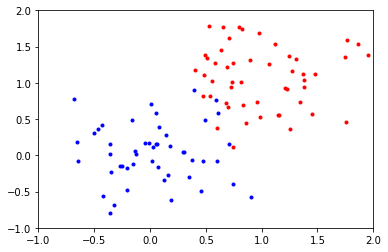

In [258]:
# Artificially make some values nan
def plot_all():
    for label, color in [(0, 'b'), (1, 'r')]:
        xy = X[labels == label]
        plt.scatter(xy[:, 0], xy[:, 1], color=color, marker='.')

    plt.axis([-1, 2, -1, 2])
    
plot_all()
plt.show()

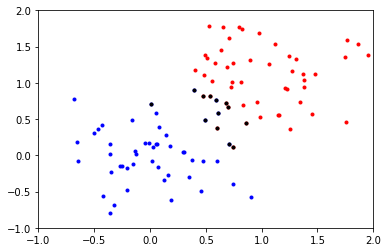

In [260]:
# Use thresholding to find some points where the clusters meet along the first principle component

from sklearn.decomposition import PCA

top_component = PCA().fit(X).components_[0]
dots = X.dot(top_component)
pca_margin = dots - dots.mean()
plot_all()
max_margin = dots.std() / 3

threshold = np.bitwise_and(-max_margin < pca_margin, pca_margin < max_margin)

xy = X[threshold]
plt.scatter(xy[:, 0], xy[:, 1], color='black', marker='.')  
plt.show()

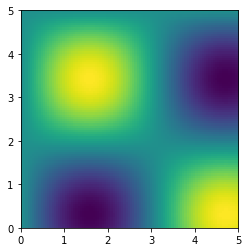

In [277]:
# Contour plots
# How to plot sin(x)*sin(y) heatmap?

xs, ys = np.mgrid[0:5:100j, 0:5:100j] # genertate mesh
Z = np.sin(xs) * np.sin(ys)
plt.imshow(Z, extent=(0, 5, 0, 5))
plt.show()

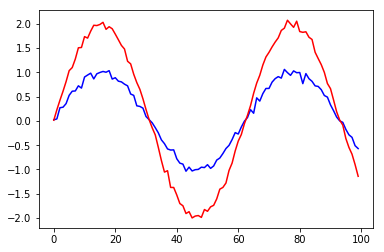

In [423]:
# Actual problem from my research:

# Suppose you have 2 sensors, each of which should take measurements
# at even intervals over the day. We want to make a method which can let us
# recover from device failure: if a sensor goes down for an extended period,
# can we impute the missing values from the other?

# Take for example two strongly correlated measured signals:

np.random.seed(1234)
s1 = np.sin(np.linspace(0, 10, 100)) + np.random.randn(100) * 0.05
s2 = 2 * np.sin(np.linspace(0, 10, 100)) + np.random.randn(100) * 0.05
plt.plot(s1, color='blue')
plt.plot(s2, color='red')
plt.show()

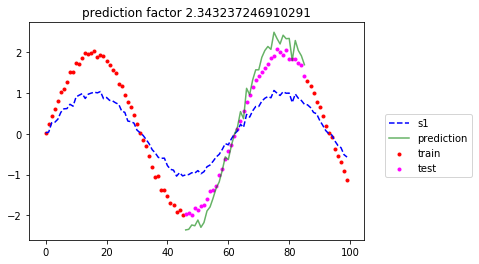

In [521]:
# Simulate a failure in sensor 2 for a random 40-index period

def holdout():
    width = 40
    start = np.random.randint(0, len(s2) - width)
    missing = slice(start, start + width)
    return missing, np.r_[:start, missing.stop:len(s2)]

# Find the most likely scaling for reconstructing s2 from s1
def factor_finder(train_ix):
    return np.mean((s2[train_ix] + 0.0001) / (s1[train_ix] + 0.0001))

test, train = holdout()
f = factor_finder(train)


def plot_factor(factor):
    times = np.arange(len(s1))
    test, train = holdout()
    plt.plot(times, s1, color='blue', ls='--', label='s1')
    plt.scatter(times[train], s2[train], color='red', marker='.', label='train')
    plt.plot(times[test], s1[test] * factor, color='green', alpha=0.6, label='prediction')
    plt.scatter(times[test], s2[test], color='magenta', marker='.', label='test')
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2)
    plt.title('prediction factor {}'.format(factor))
    plt.show()

plot_factor(f)

In [522]:
# Cubic kernel convolution and interpolation
# Complicated example; take a look on your own time!

import scipy

# From Cubic Convolution Interpolation (Keys 1981)
# Computes a piecewise cubic kernel evaluated at each data point in x
def cubic_kernel(x):
    y = np.zeros_like(x)
    x = np.fabs(x)
    if np.any(x > 2):
        raise ValueError('only absolute values <= 2 allowed')
    q = x <= 1
    y[q] = ((1.5 * x[q] - 2.5) * x[q]) * x[q] + 1
    q = ~q
    y[q] = ((-0.5 * x[q] + 2.5) * x[q] - 4) * x[q] + 2
    return y

# Everything is 1D
# Given a uniform grid of size grid_size
# and requested samples of size n_samples,
# generates an n_samples x grid_size interpolation matrix W
# such that W.f(grid) ~ f(samples) for differentiable f and samples
# inside of the grid.
def interp_cubic(grid, samples):
    delta = grid[1] - grid[0]
    factors = (samples - grid[0]) / delta
    # closest refers to the closest grid point that is smaller
    idx_of_closest = np.floor(factors)
    dist_to_closest = factors - idx_of_closest # in units of delta

    grid_size = len(grid)
    n_samples = len(samples)
    csr = scipy.sparse.csr_matrix((n_samples, grid_size), dtype=float)
    for conv_idx in range(-2, 2): # sliding convolution window
        coeff_idx = idx_of_closest - conv_idx
        coeff_idx[coeff_idx < 0] = 0 # threshold (no wraparound below)
        coeff_idx[coeff_idx >= grid_size] = grid_size - 1 # threshold (no wraparound above)
        
        relative_dist = dist_to_closest + conv_idx
        data = cubic_kernel(relative_dist)
        col_idx = coeff_idx
        ind_ptr = np.arange(0, n_samples + 1)
        csr += scipy.sparse.csr_matrix((data, col_idx, ind_ptr),
                                       shape=(n_samples, grid_size))
    return csr
    
lo, hi = 0, 1
fine = np.linspace(lo, hi, 100)
coarse = np.linspace(lo, hi, 15)
W = interp_cubic(coarse, fine)

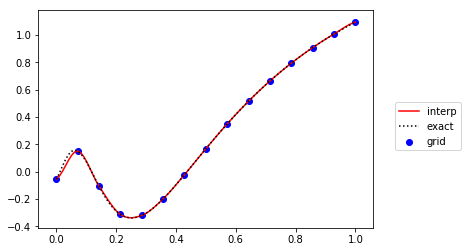

In [422]:
def f(x):
    a = np.sin(2 / (x + 0.2)) * (x + 0.1)
    # a = a * np.cos(5 * x)
    # a = a * np.cos(2 * x)
    return a

known = f(coarse) # only use coarse
interp = W.dot(known)

plt.scatter(coarse, known, color='blue', label='grid')
plt.plot(fine, interp, color='red', label='interp')
plt.plot(fine, f(fine), color='black', label='exact', ls=':')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2)
plt.show()

# Array Creation and Initialization

[doc](https://docs.scipy.org/doc/numpy-dev/reference/routines.array-creation.html)

If unspecified, default dtype is usually float, with an exception for arange.

In [434]:
display('np.linspace(4, 8, 2)')
display('np.arange(4, 8, 2)')

np.linspace(4, 8, 2) (2,)
[ 4.  8.]

np.arange(4, 8, 2) (2,)
[4 6]



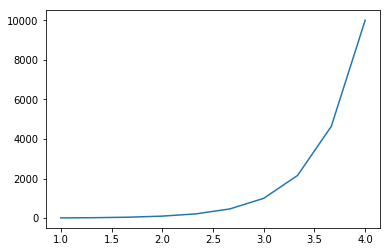

In [436]:
plt.plot(np.linspace(1, 4, 10), np.logspace(1, 4, 10))
plt.show()

In [484]:
shape = (4, 2)
print(np.zeros(shape)) # init to zero. Use np.ones or np.full accordingly

# [GOTCHA] np.empty won't initialize anything; it will just grab the first available chunk of memory
x = np.zeros(shape)
x[0] = [1, 2]
del x
print(np.empty(shape))

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.  2.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [479]:
# From iterator/list/array - can just use constructor
np.array([[1, 2], range(3, 5), np.array([5, 6])]) # auto-flatten (if possible)

array([[1, 2],
       [3, 4],
       [5, 6]])

In [482]:
# Deep copies & shape/dtype preserving creations
x = np.arange(4).reshape(2, 2)
y = np.copy(x)
z = np.zeros_like(x)
x[1, 1] = 5
print(x)
print(y)
print(z)

[[0 1]
 [2 5]]
[[0 1]
 [2 3]]
[[0 0]
 [0 0]]


In [ ]:
np.repeat() # also tile

Extremely extensive [random generation](https://docs.scipy.org/doc/numpy/reference/routines.random.html). Remember to seed!

# Transposition

**Under the hood**. So far, we've just been looking at the abstraction that NumPy offers. How does it actually keep things contiguous in memory?

We have a base array, which is one long contiguous array from 0 to size - 1.

In [485]:
x = np.arange(2 * 3 * 4).reshape(2, 3, 4)
print(x.shape)
print(x.size)

(2, 3, 4)
24


In [487]:
# Use ravel() to get the underlying flat array. np.flatten() will give you the original
print(x.ravel())
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [497]:
# np.transpose or *.T will reverse axes
print('transpose', x.shape, '->', x.T.shape)
# rollaxis pulls the argument axis to the front (largest stride)
print('rollaxis', x.shape, '->', np.rollaxis(x, 1).shape)

print()
# all the above are instances of np.moveaxis
# it's clear how these behave:

perm = np.array([0, 2, 1])
moved = np.moveaxis(x, range(3), perm)

print('arbitrary permutation', list(range(3)), perm)
print(x.shape, '->', moved.shape)
print('moved[1, 2, 0]', moved[1, 2, 0], 'x[1, 0, 2]', x[1, 0, 2])

transpose (2, 3, 4) -> (4, 3, 2)
rollaxis (2, 3, 4) -> (3, 2, 4)

arbitrary permutation [0, 1, 2] [0 2 1]
(2, 3, 4) -> (2, 4, 3)
moved[1, 2, 0] 14 x[1, 0, 2] 14


In [506]:
# When is transposition useful?
# Matrix stuff, mostly:
np.random.seed(1234)

X = np.random.randn(3, 4)
print('sigma {:.2f}, eig {:.2f}'.format(
    np.linalg.svd(X)[1].max(),
    np.sqrt(np.linalg.eigvalsh(X.dot(X.T)).max())))

sigma 3.19, eig 3.19


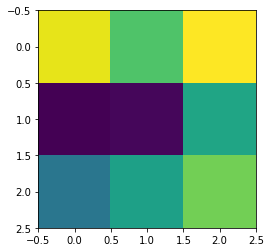

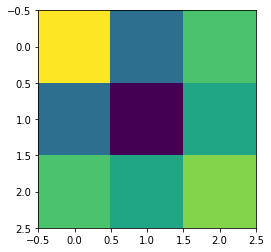

Check frob norm upper vs lower tri 0.0


In [511]:
# Create a random symmetric matrix
X = np.random.randn(3, 3)
plt.imshow(X)
plt.show()

# GOTCHA: transpose gives a view!
# X += X.T <- would be undefined
X = X + X.T
plt.imshow(X)
plt.show()

print('Check frob norm upper vs lower tri', np.linalg.norm(np.triu(X) - np.tril(X).T))

In [29]:
# Row-major, C-order
# largest axis changes fastest
A = np.arange(2 * 3).reshape(2, 3).copy(order='C')

# Row-major, Fortran-order
# smallest axis changes fastest
B = np.arange(2 * 3).reshape(2, 3).copy(order='F')

# Differences in representation don't manifest in abstraction
print(A)
print(B)

[[0 1 2]
 [3 4 5]]
[[0 1 2]
 [3 4 5]]


In [35]:
# Array manipulation functions with order option
# will use C/F ordering, but this is independent of the underlying layout
print(A.ravel())
print(A.ravel(order='F'))

# Reshape ravels an array, then folds back into shape, according to the given order
# Note reshape can infer one dimension; we leave it as -1.
print(A.ravel(order='F').reshape(-1, 3))
print(A.ravel(order='F').reshape(-1, 3, order='F'))

[0 1 2 3 4 5]
[0 3 1 4 2 5]
[[0 3 1]
 [4 2 5]]
[[0 1 2]
 [3 4 5]]


# Broadcasting

# Array Composition

In [470]:
# https://docs.scipy.org/doc/numpy/reference/routines.array-manipulation.html
# padding

### Array Transformations

In [ ]:
# config
#http://stackoverflow.com/questions/9000164/how-to-check-blas-lapack-linkage-in-numpy-scipy
    
    # conda mkl note
    
# broadcasting (diagonal matrix example)

In [ ]:
# give general perf pointers -- vectorize, vectorize, vectorize for clarity and efficiency!

# unary elementwise functions /ufunc (1-1) (frompyfunc GOTCHA doesn't C-ify)
# https://docs.scipy.org/doc/numpy/reference/ufuncs.html

# multi-ary elementwise

# reductions (many-1)

# gotcha: matrix stuff
# https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html#array-or-matrix-which-should-i-use
#don't use matrices
# (multi-ary) tensor-to-tensor (many-many) ffts, linear algebra, outer, etc. Can still vectorize, even on many-to-many

# discussion on what gets put in C (experiments showing ufunc stuff not parallelized)
# http://stackoverflow.com/questions/35500925/is-numpy-einsum-efficient-compared-to-fortran-or-c

# Re-using memory (out parameters)

In [ ]:
# 
# NOTE ALIASING
# https://github.com/numpy/numpy/pull/8043
# https://github.com/numpy/numpy/issues/8440 (search "general rule")

In [ ]:
# einsum ultilmate generalization of matrix products
# https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/
# einsum
#http://ajcr.net/Basic-guide-to-einsum
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html

# Takeaways

* Use NumPy arrays for a compact, cache-friendly, in-memory representation of structured numeric data.
* Vectorize, vectorize, vectorize! Less loops!
   * Expressive
   * Fast
   * Concise
* Rely on powerful indexing API to avoid almost all Python loops
* Rolling your own algorithm? Google it, NumPy probably has it built-in!


Keeping stuff in C as much . Vectorize as much as you can: express your logic at the heighest level you can. Keep the time spent in C. Can't optimize across numpy ops (like a C compiler would/numpy would). But do you need that? Can't parallelize except BLAS, but is it computaitonal or memory bandwidth limited?

printing 

advanced np presentation - serialization https://www.dataquest.io/blog/numpy-cheat-sheet/?imm_mid=0f1262&cmp=em-data-na-na-newsltr_20170426

not mentioned stuff -- storage/io , gpu, numba

In [18]:
#Maybe: sparse matrices, scipy acceleration
#    more ideas:
#        https://speakerdeck.com/jakevdp/losing-your-loops-fast-numerical-computing-with-numpy-pycon-2015
# I/O

# https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html -> don't use it; prefer indexing [GOTCHAhttps://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html]

In [ ]:
# http://cs231n.github.io/python-numpy-tutorial/

# other data
# https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html
# https://docs.scipy.org/doc/numpy/reference/routines.polynomials.html